**PART 7: Advanced Topics on Gradient Descent**

Importing libraries

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import norm 
from sklearn.model_selection import train_test_split
from scipy.linalg import svdvals
from scipy.optimize import fmin_l_bfgs_b
import math
from matplotlib.pyplot import figure
#figure(figsize=(10, 5), dpi=80)

Loading and cleaning the dataset

In [2]:
data=pd.read_csv('energy.csv')
data_copy=data.copy()
A = data_copy[['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area','Overall_Height', 'Orientation', 'Glazing_Area','Glazing_Area_Distribution']]
y=data_copy[['Heating_Load']]

In [3]:
m=A.mean(axis=0)
s=A.std(axis=0)
my=y.mean()

A=(A-m)/s
y=y-my

n=A.shape[0]
d=A.shape[1]

A_mat=A.to_numpy()
y_mat=y.to_numpy().reshape(n)

Usefull functions (as seen in Mr Clément Royer practica sessions):

In [5]:
# Python class for regression problems
class RegPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            A: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of A
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
            lbda: Regularization parameter
    '''
   
    # Instantiate the class
    def __init__(self, A, y,lbda=0,loss='l2'):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        self.loss = loss
        self.lbda = lbda
        
    
    # Objective value
    def fun(self, x):
        if self.loss=='l2':
            return norm(self.A.dot(x) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            return np.mean(np.log(1. + np.exp(-yAx))) + self.lbda * norm(x) ** 2 / 2.
    
    # Partial objective value
    def f_i(self, i, x):
        if self.loss=='l2':
            return norm(self.A[i].dot(x) - self.y[i]) ** 2 / (2.) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAxi = self.y[i] * np.dot(self.A[i], x)
            return np.log(1. + np.exp(- yAxi)) + self.lbda * norm(x) ** 2 / 2.
    
    # Full gradient computation
    def grad(self, x):
        if self.loss=='l2':
            return self.A.T.dot(self.A.dot(x) - self.y) / self.n + self.lbda * x
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            aux = 1. / (1. + np.exp(yAx))
            return - (self.A.T).dot(self.y * aux) / self.n + self.lbda * x
    
    # Partial gradient
    def grad_i(self,i,x):
        a_i = self.A[i]
        if self.loss=='l2':
            return (a_i.dot(x) - self.y[i]) * a_i + self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i]* a_i.dot(x)))
            grad += self.lbda * x
            return grad
        
    # Partial gradient knowing the model (useful for certain gradient techniques)
    def grad_ai(self,i,aix,x=None):
        a_i = self.A[i]
        if self.loss=='l2':
            grad = (aix - self.y[i]) * a_i 
            if (self.lbda>0):
                grad += self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i]* aix))
            if (self.lbda>0):
                grad += self.lbda * x
        return grad        

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.A, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.A)
            mu = min(s)**2 / self.n 
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

In [6]:
def gradient_descent(f,grad,x0,T,step,verbose=False):
    if verbose:
      print('Running gradient descent')
    
    n = np.shape(x0)[0]
    
    # Initialize lists of iterates and objective values
    iterates = np.zeros((n,T+1))
    vals = np.zeros(T+1)
    iterates[:,0] = x0
    vals[0] = f(x0)
    
    x = x0
    for t in range(1,T+1):
        # Descent step
        x = x - step * grad(x)
        # Record
        iterates[:,t] = x
        vals[t] = f(x)
    if verbose:    
      print('Final value: ',vals[T])
    
    return (iterates,vals)

In [16]:
def heavy_ball(f,grad,x0,T,step,gamma,verbose=False):

    if verbose:
      print('Running heavy ball')
    
    n = np.shape(x0)[0]
    
    # Initialize lists of iterates and objective values
    iterates = np.zeros((n,T+1))
    vals = np.zeros(T+1)
    iterates[:,0] = x0
    vals[0] = f(x0)
    
    x = x0
    m = grad(x0) # initial momentum
    for t in range(1,T+1):
        
        m = (1-gamma) * grad(x) + gamma * m # average current momentum and gradient
        x = x - step * m # "gradient" step
        iterates[:,t] = x
        vals[t] = f(x)
    if verbose:    
      print('Final value: ',vals[T])
    
    return (iterates,vals)

In [8]:
def d_pnorm(x,p):
  diag_X=np.zeros(x.shape[0])
  for i in range(x.shape[0]):
    diag_x=np.sign(x[i])*(np.abs(x[i])/norm(x,p))**(p-1)
  return diag_X

***Question 1:***

In [9]:
#instantiating a regression problem, no ridge penalty
x_init = np.zeros(d)
lbda = 1./n**(0.5)
pblinreg = RegPb(A_mat, y_mat,lbda,loss='l2')

#Using L-BFGS-B algorithm to determine a solution

x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)

# Compute the optimal solution for linear regression
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))

5.687540198729592
4.397017274476509e-09


Testing Heavy Ball algorithm with different values of stepsize and gamma

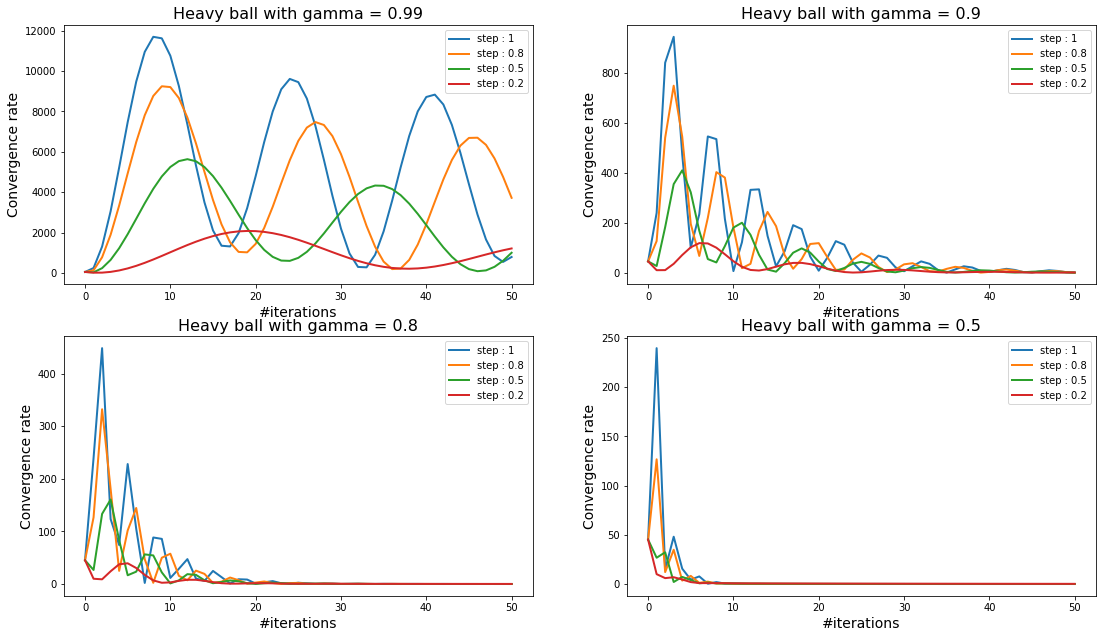

In [17]:
T = 50
x0 = np.zeros(d)
stepsizes = [1,0.8,0.5,0.2]
gammas = [0.99,0.9,0.8,0.5]
nvals = len(stepsizes)

fig,axes=plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5)
x_init = np.zeros(d)
for i, ax in enumerate(axes.flat):
  for val_step in stepsizes:
    ax.set_title(f"Heavy ball with gamma = {gammas[i]}", fontsize=16)
    iterates_step,vals_step=heavy_ball(lambda x :pblinreg.fun(x),lambda x :pblinreg.grad(x),x0,T,val_step,gammas[i])
    ax.plot(vals_step-f_min_lin, label="step : "+str(val_step), lw=2)
    ax.set_xlabel("#iterations", fontsize=14)
    ax.set_ylabel("Convergence rate", fontsize=14)
    ax.legend(loc=1)

***Question 2:***

Comparing Gradient Descent with Heavy Ball

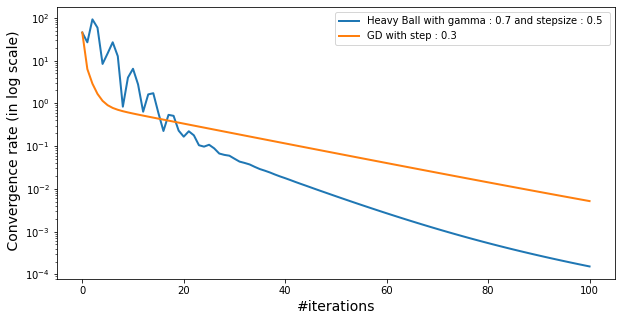

In [18]:
plt.figure(figsize=(10, 5))
plt.set_cmap("RdPu")
iterates,vals=heavy_ball(lambda x :pblinreg.fun(x),lambda x :pblinreg.grad(x),x0,100,0.5,0.7)
iterates_gd,vals_gd=gradient_descent(lambda x :pblinreg.fun(x),lambda x :pblinreg.grad(x),x0,100,0.3)
plt.semilogy(vals-f_min_lin, label=f"Heavy Ball with gamma : {0.7} and stepsize : {0.5} ", lw=2)
plt.semilogy(vals_gd-f_min_lin, label=f"GD with step : {0.3}", lw=2)

plt.xlabel("#iterations", fontsize=14)
plt.ylabel(" Convergence rate (in log scale)", fontsize=14)
plt.legend(loc=1)

***Question 3:***

Adding non-convex penalty term to the ojective function (different than l1 and l2 already covered).

Minimizing the loss with both GD and Heavy Ball

<ipython-input-8-47eef61c3422>:4: RuntimeWarning: invalid value encountered in double_scalars
  diag_x=np.sign(x[i])*(np.abs(x[i])/norm(x,p))**(p-1)


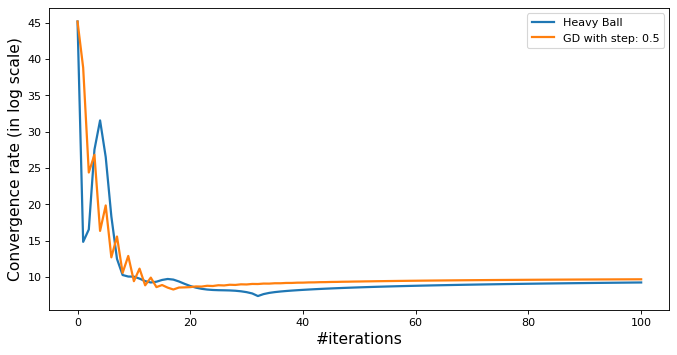

In [32]:
p=0.4
lbda=1/n**(0.5)
f = lambda x : pblinreg.fun(x) + lbda*norm(x,p)
step=0.5
figure(figsize=(10, 5), dpi=80)

gradf = lambda x : pblinreg.grad(x) + lbda*p*d_pnorm(x,p)*x

iterates,vals=heavy_ball(f,gradf,x0,100,0.2,0.7)
iterates_gd_p,vals_gd_p=gradient_descent(f,gradf,x0,100,step,verbose=False)

plt.plot(vals - f_min_lin, label="Heavy Ball", lw=2)
plt.plot(vals_gd_p - f_min_lin, label=f"GD with step: {step}", lw=2)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Convergence rate (in log scale)", fontsize=14)
plt.legend(loc=1)